#  11.5 Capstone Two: Exploratory Data Analysis

### Step 1: Loading Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression


from scipy.stats import t
from scipy import stats

from numpy.random import seed
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from library.sb_utils import save_file

In [2]:
#Loading the two csv with and without dummy variables (one-hot variable)
df = pd.read_csv('data/insurance_r1.csv') 
df_r = pd.read_csv('data/insurance_regression.csv') 

### Step 2: Explorating the data

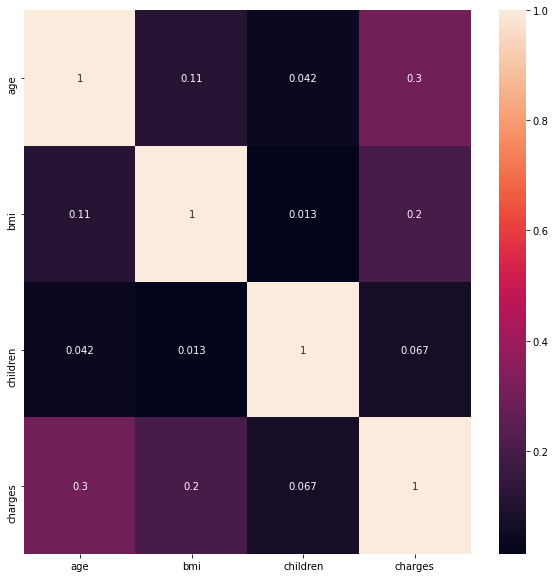

In [3]:
plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

From the heatmap, the numerical factors seem to have no strong correlation between each other.

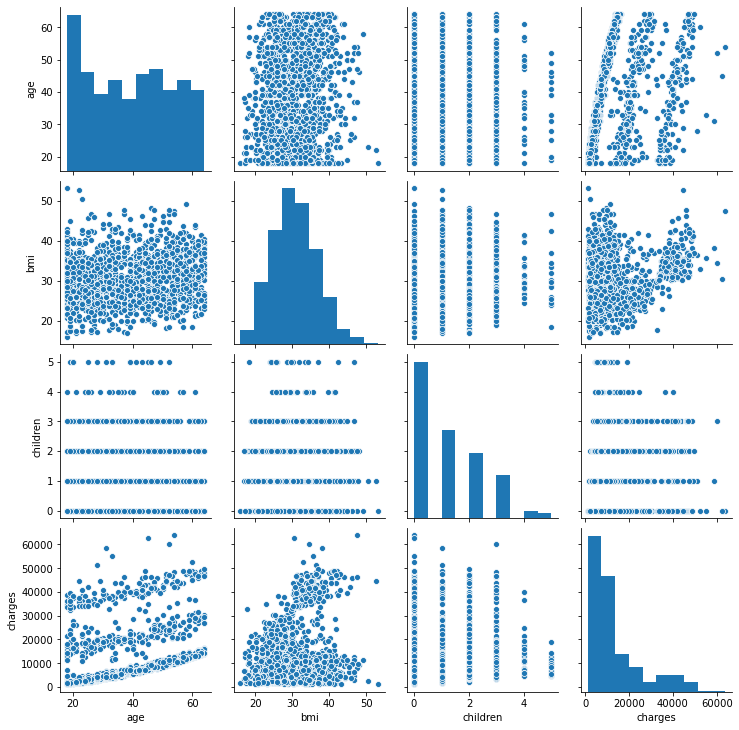

In [4]:
sns.pairplot(df)

In [5]:
# define useful function to create scatterplots of ticket prices against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'charges', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='Insurance fee')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [6]:
features = [i for i in df.columns if i not in ['charges']]

From the scatter plot we can observe:

Age: There are 3 discrete line we can draw from the scatter plot. This indicate clusters may exist

Sex: No obvious different in insurance fee between male and female

bmi: There is no obvious trend but we can observe that most people which have 30k+ insurance free 
have bmi 30 or higher.

children: The people which have 4 and 5 children tend to have a lower insurance fee compared with people who have 1-3 children

smoker: Smoker have higher insurance fee

region: There is no obvious different between people in different region

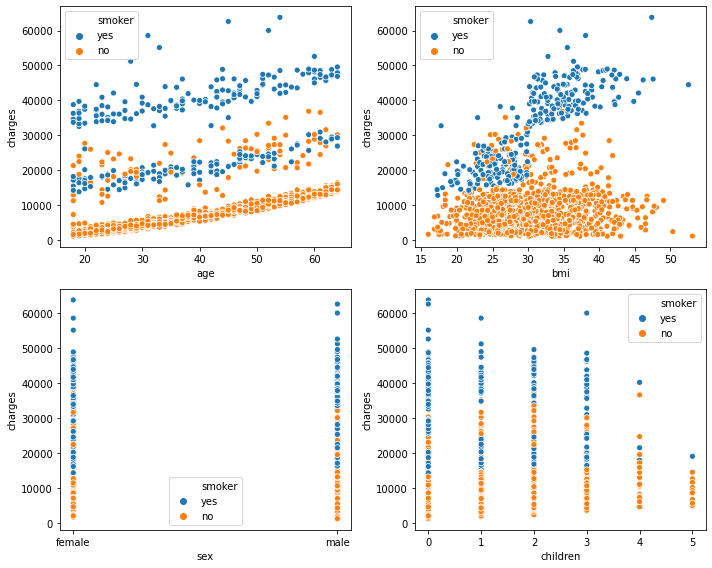

In [8]:
#Explore any cluster formed by smoking behaviour
fig, axes = plt.subplots(2,2,figsize = (10,8))
sns.scatterplot(x = 'age', y = 'charges',data = df,hue = 'smoker',ax = axes[0,0])
sns.scatterplot(x = 'bmi', y = 'charges',data = df,hue = 'smoker',ax = axes[0,1])
sns.scatterplot(x = 'children', y = 'charges',data = df,hue = 'smoker',ax = axes[1,1])
sns.scatterplot(x = 'sex', y = 'charges',data = df,hue = 'smoker',ax = axes[1,0])

plt.tight_layout()
plt.show()

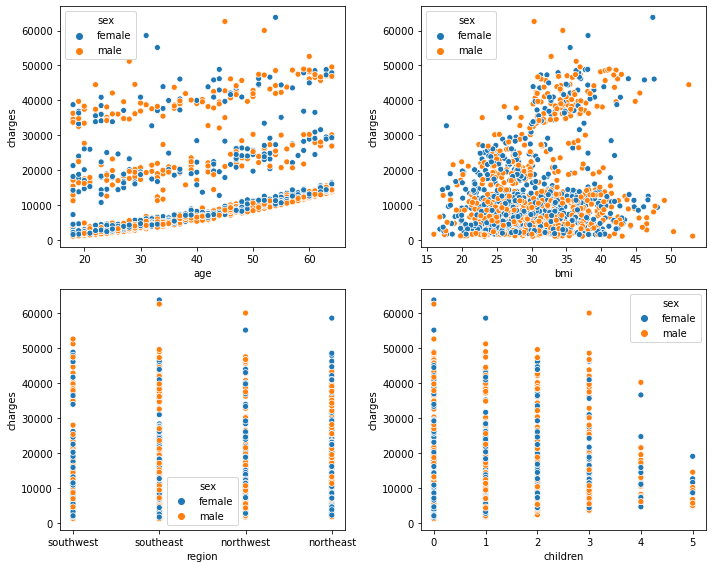

In [9]:
#Explore any cluster formed by sex
fig, axes = plt.subplots(2,2,figsize = (10,8))
sns.scatterplot(x = 'age', y = 'charges',data = df,hue = 'sex',ax = axes[0,0])
sns.scatterplot(x = 'bmi', y = 'charges',data = df,hue = 'sex',ax = axes[0,1])
sns.scatterplot(x = 'children', y = 'charges',data = df,hue = 'sex',ax = axes[1,1])
sns.scatterplot(x = 'region', y = 'charges',data = df,hue = 'sex',ax = axes[1,0])
plt.tight_layout()


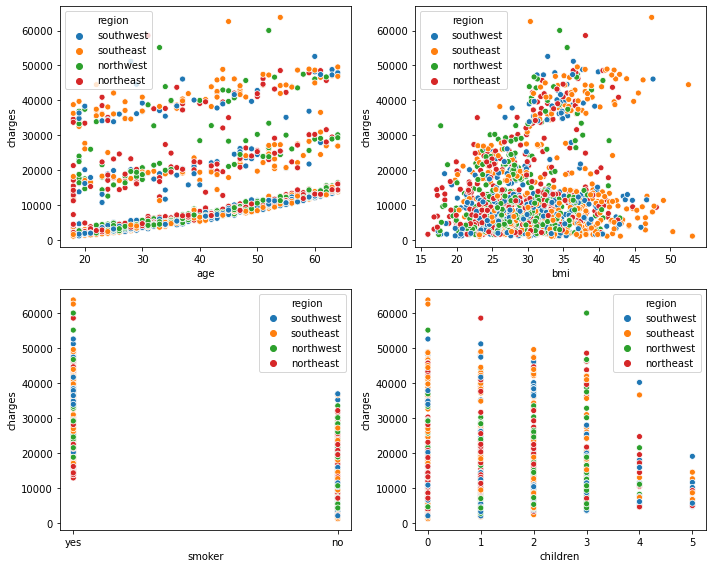

In [10]:
#Explore any cluster formed by region
fig, axes = plt.subplots(2,2,figsize = (10,8))
sns.scatterplot(x = 'age', y = 'charges',data = df,hue = 'region',ax = axes[0,0])
sns.scatterplot(x = 'bmi', y = 'charges',data = df,hue = 'region',ax = axes[0,1])
sns.scatterplot(x = 'children', y = 'charges',data = df,hue = 'region',ax = axes[1,1])
sns.scatterplot(x = 'smoker', y = 'charges',data = df,hue = 'region',ax = axes[1,0])
plt.tight_layout()


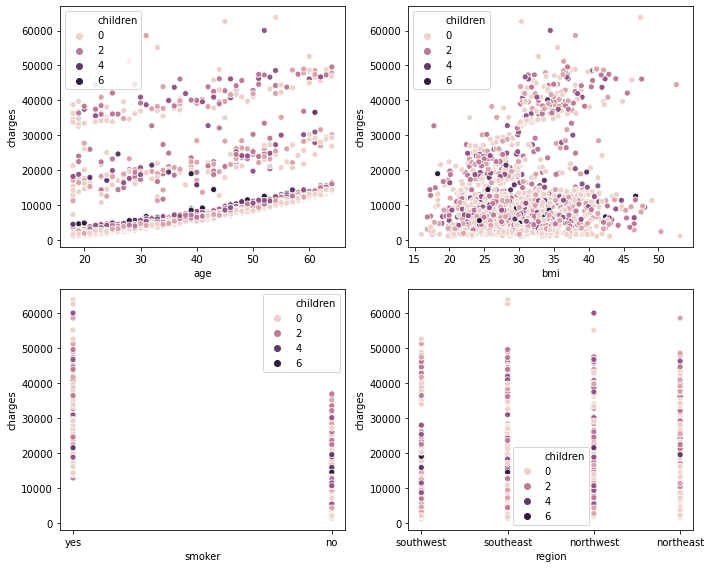

In [11]:
#Explore any cluster formed by sex family size
fig, axes = plt.subplots(2,2,figsize = (10,8))
sns.scatterplot(x = 'age', y = 'charges',data = df,hue = 'children',ax = axes[0,0])
sns.scatterplot(x = 'bmi', y = 'charges',data = df,hue = 'children',ax = axes[0,1])
sns.scatterplot(x = 'region', y = 'charges',data = df,hue = 'children',ax = axes[1,1])
sns.scatterplot(x = 'smoker', y = 'charges',data = df,hue = 'children',ax = axes[1,0])
plt.tight_layout()


We can observe a cluster from smoking behaviour. The cluster indicates that both insurance fee of the smokers and non-smokers increase with age (with similar slope) while the smokers have a higher y-intercept (insurance fee). Moreover, the insurance fee of non-smokers have no obvious trend with bmi but that of the smokers increase with bmi.

### Step 3: Statistical Test

### t-test


t-test is adopted to compare the significant of binary categorical features e.g. sex and smoking behaviour.
The null hypothesis is that the average medical cost for customer is the same regardless their gender and smoking behaviour. The alternative hypothesis is that these means are different. The test to use here is the two-sample t-test. We are assuming the two groups have equal variance.

In [56]:
#t-test for smoker
smoker = df[df['smoker']=='yes'].charges
nonsmoker = df[df['smoker']=='no'].charges
result = ttest_ind(nonsmoker,smoker)
print('t_stat is {}'.format(result[0]),
      '\np-value is {}'.format(result[1]))

t_stat is -46.64479471596229 
p-value is 1.4067191603310468e-282


In [57]:
#t-test for sex
female = df[df['sex']=='female'].charges
male = df[df['sex']=='male'].charges
result = ttest_ind(female,male)
print('t_stat is {}'.format(result[0]),
      '\np-value is {}'.format(result[1]))

t_stat is -2.1243917376752517 
p-value is 0.03382075594788481


For both gender and smoking beahaviour, the p-value < 0.05. Hence, for both cases we can reject the null hypothesis and accept the alternative hypothesis that these means are different (in 95% confident interval). In other word, gender and smoking behaviour may cause different in medical cost. 

### One-way ANOVA

One-way ANOVA is adopted to compare the significant of categorical features which contains more than two different levels e.g. region and family size.
The null hypothesis is: there is no difference in the population means of the different levels of factor A (the only factor). The alternative hypothesis is: the means are not the same.

In [58]:
#One-Way ANOVA for region
SW = df[df['region']=='southwest'].charges
SE = df[df['region']=='southeast'].charges
NW = df[df['region']=='northwest'].charges
NE = df[df['region']=='northeast'].charges
f_oneway(SW, SE, NW,NE)


F_onewayResult(statistic=2.926140081112945, pvalue=0.03276287240528303)

In [59]:
#One-Way ANOVA for family size

chil_0 = df[df['children']==0].charges
chil_1 = df[df['children']==1].charges
chil_2 = df[df['children']==2].charges
chil_3 = df[df['children']==3].charges
chil_4 = df[df['children']==4].charges
chil_5 = df[df['children']==5].charges

f_oneway(chil_0, chil_1, chil_2,chil_3,chil_4,chil_5)


F_onewayResult(statistic=3.2687345369236396, pvalue=0.006133446579312973)

### Chi-square test

Chi-square test is adopted to check for inter-feature correlation. The Chi-Square statistic is commonly used for testing relationships between categorical variables. The null hypothesis of the Chi-Square test is that no relationship exists on the categorical variables in the population; they are independent.


NE            0.934121
bmi           0.880317
children_0    0.801551
children_1    0.457405
children_2    0.352404
children_4    0.292758
NW            0.247673
SW            0.237046
children_3    0.177208
children_5    0.116397
sex           0.048751
age           0.035967
SE            0.033177
dtype: float64


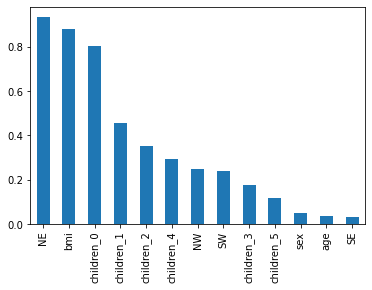

In [60]:
#chi square for checking correlation between categorical features - smoker

X = df_r.drop(['charges','smoker'],axis=1)
y = df_r.smoker
chi_scores = chi2(X,y)

chi_scores
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()

With 95% confidence interval, we can expect smoking behaviour is correlated with sex and age. Moreover, the p-value for SE is less then 0.05 too. For further investigation, we find 91 out of 364 people who live in SE are smoker which has higher proportion than other region (NE: out 68 of 324, NW: 59 out of 325 and SW 59 out of 325)

children_2    0.982820
NE            0.949041
children_3    0.906385
SW            0.904622
children_1    0.787592
NW            0.691176
children_5    0.667070
children_0    0.658743
SE            0.583474
children_4    0.581353
age           0.104364
bmi           0.061699
smoker        0.012514
dtype: float64


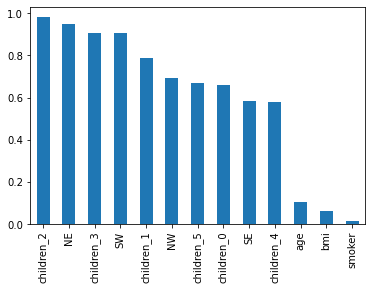

In [17]:
#chi square for checking correlation between categorical features - sex

X = df_r.drop(['charges','sex'],axis=1)
y = df_r.sex
chi_scores = chi2(X,y)

chi_scores
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()


Sex may be correlated with bmi and smoking behaviour

sex       9.958168e-01
NE        8.513817e-01
bmi       8.317610e-01
SE        7.515155e-01
SW        6.648705e-01
smoker    3.618478e-01
NW        3.046945e-01
age       6.397347e-07
dtype: float64


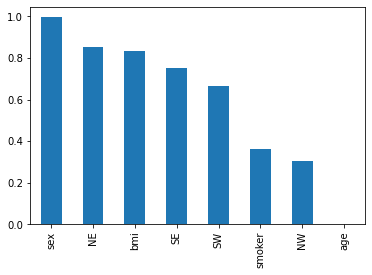

In [61]:
#chi square for checking correlation between categorical features - smoker

X = df_r.drop(['charges','children_0','children_1','children_2','children_3','children_4','children_5'],axis=1)
y = df['children']
chi_scores = chi2(X,y)

chi_scores
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()

family size may be correlated with age

children_4    8.574708e-01
children_1    8.448962e-01
children_0    8.156731e-01
age           7.479726e-01
children_2    5.774635e-01
children_3    3.727633e-01
smoker        1.224779e-01
children_5    9.937570e-02
bmi           1.718298e-28
dtype: float64


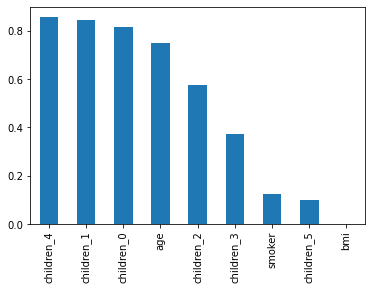

In [20]:
#chi square for checking correlation between categorical features - region

X = df_r.drop(['charges','sex','NE','SE','SW','NW'],axis=1)
y = df['region']
chi_scores = chi2(X,y)

chi_scores
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()

Region may be correlated with bmi and large family size (5 children)

### Step 4: Feature importance and selection

### Recursive Feature Elimination (RFE)

RFE is a wrapper-type feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. This is in contrast to filter-based feature selections that score each feature and select those features with the largest (or smallest) score.

In [63]:
#Feature selection - Recursive Feature Elimination (RFE) for Random Forest Classifier
X = df_r.drop(['charges'],axis=1)
df['charges_gp'] = pd.cut(df['charges'],bins=[-np.inf, 5000, 10000, 15000,20000,25000,30000,35000,40000,45000,
                                              50000,55000,60000,np.inf],labels=[1, 2, 3,4,5,6,7,8,9,10,11,12,13])
y= df['charges_gp']


In [22]:
rfc = RandomForestClassifier(random_state = 10)
rfecv = RFECV(estimator = rfc,step = 1, cv = StratifiedKFold(10),scoring ='accuracy')
rfecv.fit(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=10), scoring='accuracy')

In [23]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 9


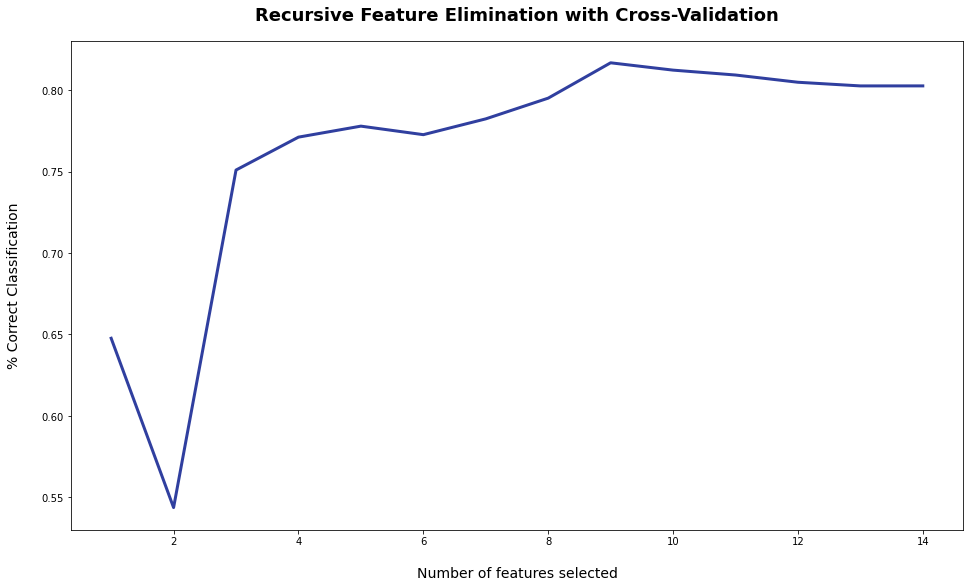

In [24]:

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [25]:

print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[ 6  7  8  9 12]


In [46]:
rfecv.estimator_.feature_importances_


array([0.51954836, 0.02559724, 0.2143331 , 0.13918734, 0.03138877,
       0.01985786, 0.0155418 , 0.01742761, 0.0171179 ])

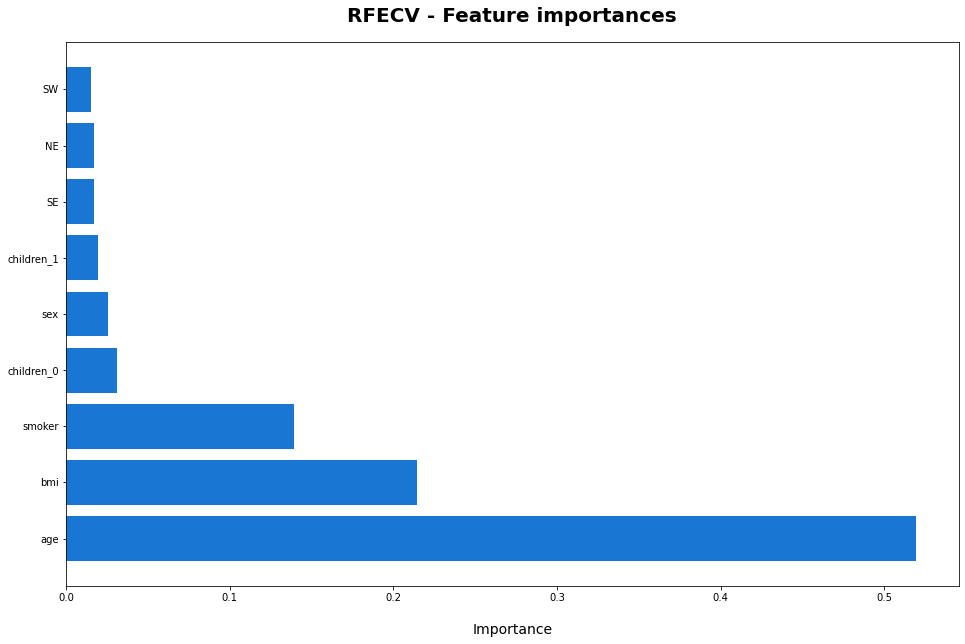

In [27]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Chi-square for feature Selection

Chi-square score is adopted for investigating which features are more correlated to the medical cost

In [49]:
#Univariate Selection
X = df_r.drop(['charges'],axis=1)
y= df['charges_gp']
bestfeatures = SelectKBest(score_func = chi2, k ='all')
fit = bestfeatures.fit(X,y)

In [50]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [51]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featureScores.Score

0     4240.976372
1       10.809406
2      172.322010
3      765.738956
4       60.975720
5       26.774848
6       22.105797
7       26.156434
8       11.628431
9       10.217532
10      14.930369
11      24.019221
12       8.601303
13       7.504769
Name: Score, dtype: float64

      Features        Score
0          age  4240.976372
3       smoker   765.738956
2          bmi   172.322010
4   children_0    60.975720
5   children_1    26.774848
7   children_3    26.156434
11          SE    24.019221
6   children_2    22.105797
10          SW    14.930369
8   children_4    11.628431
1          sex    10.809406
9   children_5    10.217532
12          NW     8.601303
13          NE     7.504769


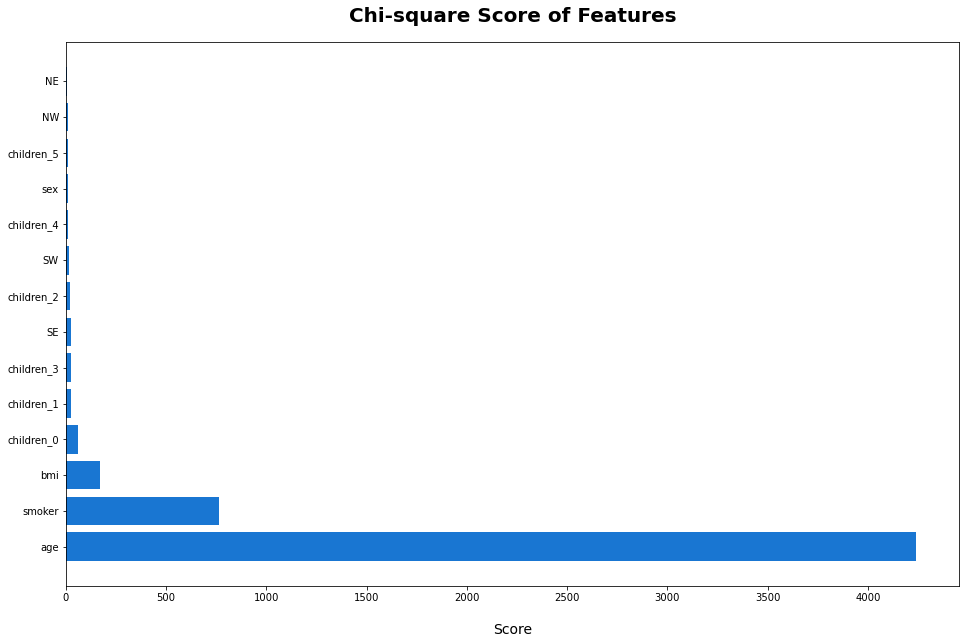

In [53]:
print(featureScores.nlargest(14,'Score'))
plt.figure(figsize=(16, 10))
plt.barh(y=featureScores.nlargest(14,'Score')['Features'], width=featureScores.nlargest(14,'Score')['Score'], color='#1976D2')
plt.title('Chi-square Score of Features', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Score', fontsize=14, labelpad=20)
plt.show()

NE             8.225361e-01
NW             7.365542e-01
children_5     5.968832e-01
sex            5.453195e-01
children_4     4.759629e-01
SW             2.452665e-01
children_2     3.635105e-02
SE             2.021893e-02
children_3     1.019983e-02
children_1     8.324802e-03
children_0     1.497887e-08
bmi            1.598695e-30
smoker        3.661548e-156
age            0.000000e+00
dtype: float64


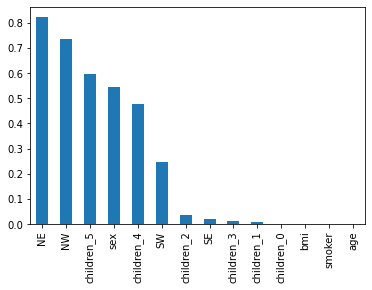

In [54]:
X = df_r.drop(['charges'],axis=1)
y= df['charges_gp']
chi_scores = chi2(X,y)

chi_scores
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()